<a href="https://colab.research.google.com/github/unica-isde/isde/blob/master/notebooks/lab02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python - Programming Exercise

In this programming exercise, we will implement a simple machine-learning algorithm to classify handwritten digits.

We start by writing a simple function to load the popular MNIST handwritten digit images and visualize some examples.

In [1]:
import pandas as pd
import numpy as np


def load_mnist_data(filename, n_samples=None):
    """This function returns MNIST handwritten digits and labels as ndarrays."""
    data = pd.read_csv(filename)
    data = np.array(data)  # cast pandas dataframe to numpy array
    if n_samples is not None:  # only returning the first n_samples
        data = data[:n_samples, :]
    y = data[:,0]
    x = data[:,1:] / 255.0
    return x, y


# loads data from a CSV file hosted in our repository
filename = "https://github.com/unica-isde/isde/raw/master/data/mnist_data.csv"

x, y = load_mnist_data(filename) # , n_samples=1000)
print(x.shape)
print(y.shape)
print(y, type(y))
print(x, type(x))

(2890, 784)
(2890,)
[6 7 0 ... 4 5 6] <class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] <class 'numpy.ndarray'>


Let's count how many digit images we have for each class.

In [2]:
num_classes = np.unique(y).size  # number of unique elements in y
counts = np.zeros(shape=(num_classes,), dtype=int)

for i in range(num_classes):
    counts[i] = np.array(y==i).sum()
    print(i, counts[i])

print(counts)

0 300
1 329
2 291
3 297
4 269
5 250
6 291
7 305
8 279
9 279
[300 329 291 297 269 250 291 305 279 279]


Let's plot some digit examples. Each digit is stored as a row vector of 784 elements. To display it as an image, we need to reshape this vector as a 28x28 matrix, and then use the command ```imshow```.

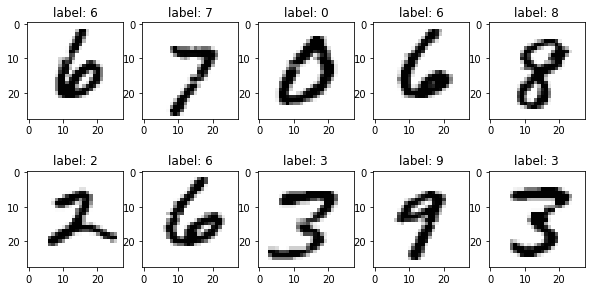

In [3]:
import matplotlib.pyplot as plt


def plot_image(im, shape=(28,28)):
    '''Plot one image after reshaping.'''
    im = im.reshape(shape)  # reshape the digit to be 28x28
    plt.imshow(im, cmap='binary')

def plot_ten_images(x, y, shape=(28,28)):
    '''Plot the first ten images from x in a 2x5 plot, after reshaping.'''
    plt.figure(figsize=(10,5))  # new figure with height=5, width=10
    for i in range(10):
        plt.subplot(2, 5, i+1)
        image = x[i, :]
        plot_image(image, shape=shape)
        plt.title("label: " + str(y[i]))


plot_ten_images(x,y,shape=(28,28))

## Splitting data into training and test

In [4]:
# x: 1000, 784; y=1000
tr_frac = 0.6

n_samples = x.shape[0]

n_tr = int(tr_frac*n_samples)
n_ts = n_samples - n_tr

# create a vector of indices from 0 to 999 = [0, 1, 2, ... 999]
idx = np.linspace(0, n_samples, num=n_samples, endpoint=False, dtype='int')
np.random.shuffle(idx)  # shuffling the elements of idx (in-place)

print(idx[:10])

tr_idx = idx[:n_tr]  # extract the subset of training indices (first n_tr samples)
ts_idx = idx[n_tr:]  # extract the subset of training indices (first n_tr samples)

xtr = x[tr_idx,:] 
ytr = y[tr_idx]

xts = x[ts_idx,:] 
yts = y[ts_idx]

print(n_tr, tr_idx.size)
print(n_ts, ts_idx.size)
print(xtr.shape, ytr.shape)
print(xts.shape, yts.shape)

assert(n_tr==tr_idx.size)
assert(n_ts==ts_idx.size)

[2037 1579  488   89 1589 1458  694 1599 1296 1587]
1734 1734
1156 1156
(1734, 784) (1734,)
(1156, 784) (1156,)


In [5]:
def data_split(x, y, tr_frac=0.6):
    n_samples = x.shape[0]

    n_tr = int(tr_frac*n_samples)
    n_ts = n_samples - n_tr

    # create a vector of indices from 0 to 999 = [0, 1, 2, ... n_samples-1]
    idx = np.linspace(0, n_samples, num=n_samples, endpoint=False, dtype='int')
    np.random.shuffle(idx)  # shuffling the elements of idx (in-place)

    tr_idx = idx[:n_tr]  # extract the subset of training indices 
    ts_idx = idx[n_tr:]  # extract the subset of test indices 

    # check coherence with the number of extracted elements
    assert(n_tr==tr_idx.size)
    assert(n_ts==ts_idx.size)

    xtr = x[tr_idx,:] 
    ytr = y[tr_idx]
    xts = x[ts_idx,:] 
    yts = y[ts_idx]
    return xtr, ytr, xts, yts


tr_frac = 0.6
xtr, ytr, xts, yts = data_split(x, y, tr_frac=tr_frac)


## Implementing the fit function

We now implement the fit function of the nearest-mean-centroid (NMC) classifier. It consists of estimating the average centroid for each class. Then, during prediction, the classifier will assign the input sample to the class of the closest centroid.

Let's start by estimating the centroid for class 0.

188
188
(784,)


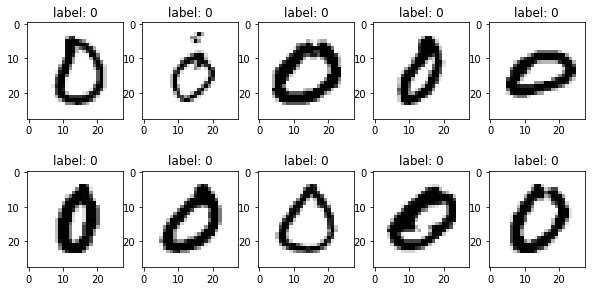

In [6]:
# fit my classification function (estimate centroids from training data)
x0 = xtr[ytr==0, :]
y0 = ytr[ytr==0]

print(y0.size)
print(x0.shape[0])

plot_ten_images(x0,y0,shape=(28,28))

centroid0 = x0.mean(axis=0)
print(centroid0.shape)

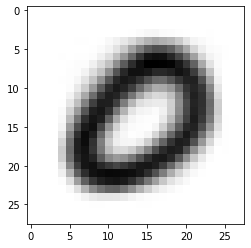

In [7]:
plot_image(centroid0)

We can now generalize our algorithm to compute the centroids of all classes.

(10, 784)


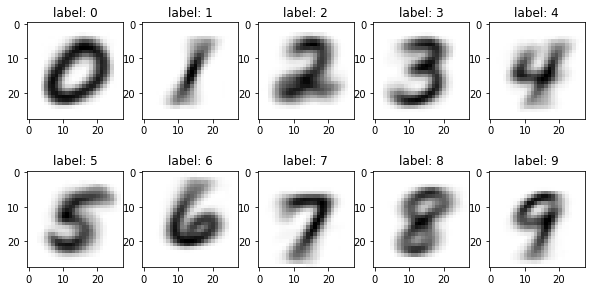

In [8]:
# compute centroid for each class
num_features = xtr.shape[1]
centroids = np.zeros(shape=(num_classes, num_features))
labels = np.zeros(shape=(num_classes, ), dtype='int')
print(centroids.shape)

for i in range(num_classes):
    xi = xtr[ytr==i, :]  # all digits from class i
    centroids[i,:] = xi.mean(axis=0)  # average digit for class i
    labels[i] = i  # label of i-th centroid

plot_ten_images(centroids,labels,shape=(28,28))

Finally, we create the function ```fit```.

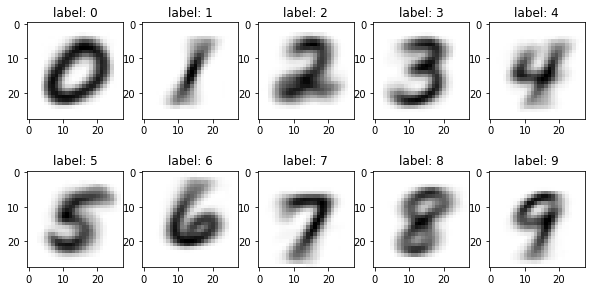

In [15]:
def fit(x_tr, y_tr):
    """Estimate the centroid for each class from the training data"""
    labels = np.unique(y_tr) 
    centroids = np.zeros(shape=(labels.size, x_tr.shape[1]))

    for i, label in enumerate(labels):
        centroids[i,:] = x_tr[y_tr==label, :].mean(axis=0)  # centr. for class i

    return centroids, labels


centroids, labels = fit(xtr, ytr)

plot_ten_images(centroids,labels,shape=(28,28))

## Predict

In [10]:
# xts, centroids

n_samples = xts.shape[0]
n_classes = centroids.shape[0]
dist = np.zeros(shape=(n_samples, n_classes))
ypred = np.zeros(shape=(n_samples, ), dtype='int')

print(dist.shape)

for i in range(n_samples):
    for k in range(n_classes):
        dist[i,k] = np.linalg.norm(xts[i,:]-centroids[k,:], ord=2)
    ypred[i] = np.argmin(dist[i,:])

ypred2 = np.argmin(dist, axis=1)
print(ypred==ypred2)

dist2 = np.zeros(shape=(n_samples, n_classes))
for i in range(n_samples):
    dist2[i,:] = np.linalg.norm(xts[i,:]-centroids, ord=2, axis=1)
print(dist2)

(1156, 10)
[ True  True  True ...  True  True  True]
[[9.43200426 8.7588766  7.6320701  ... 8.31379008 7.16683703 6.51529299]
 [9.46311483 7.89757756 7.48725704 ... 8.15301221 6.45012921 7.56358723]
 [8.93136554 8.35288005 8.27245979 ... 6.69798339 7.0391999  5.8127405 ]
 ...
 [8.69252527 9.37170297 6.24023453 ... 8.07414166 7.69937411 8.44608572]
 [9.40444617 9.13321537 7.80564674 ... 9.37666901 8.77091258 9.7475813 ]
 [9.60934696 9.77408603 9.41026704 ... 8.91474088 6.90341196 7.88296315]]


In [11]:
dist3 = np.zeros(shape=(n_samples, n_classes))
for k in range(n_classes):
    m = xts-centroids[k,:]
    print(m.shape)
    dist3[:, k] = np.linalg.norm(xts-centroids[k,:], ord=2, axis=1)
print(dist3)

(1156, 784)
(1156, 784)
(1156, 784)
(1156, 784)
(1156, 784)
(1156, 784)
(1156, 784)
(1156, 784)
(1156, 784)
(1156, 784)
[[9.43200426 8.7588766  7.6320701  ... 8.31379008 7.16683703 6.51529299]
 [9.46311483 7.89757756 7.48725704 ... 8.15301221 6.45012921 7.56358723]
 [8.93136554 8.35288005 8.27245979 ... 6.69798339 7.0391999  5.8127405 ]
 ...
 [8.69252527 9.37170297 6.24023453 ... 8.07414166 7.69937411 8.44608572]
 [9.40444617 9.13321537 7.80564674 ... 9.37666901 8.77091258 9.7475813 ]
 [9.60934696 9.77408603 9.41026704 ... 8.91474088 6.90341196 7.88296315]]


In [12]:
from sklearn.metrics import pairwise_distances

dist = pairwise_distances(xts, centroids)  # dist.shape = (400, 10)
ypred = np.argmin(dist, axis=1)

print(dist)

[[9.43200426 8.7588766  7.6320701  ... 8.31379008 7.16683703 6.51529299]
 [9.46311483 7.89757756 7.48725704 ... 8.15301221 6.45012921 7.56358723]
 [8.93136554 8.35288005 8.27245979 ... 6.69798339 7.0391999  5.8127405 ]
 ...
 [8.69252527 9.37170297 6.24023453 ... 8.07414166 7.69937411 8.44608572]
 [9.40444617 9.13321537 7.80564674 ... 9.37666901 8.77091258 9.7475813 ]
 [9.60934696 9.77408603 9.41026704 ... 8.91474088 6.90341196 7.88296315]]


In [13]:
def predict_for_loops(xts, centroids):
    n_samples = xts.shape[0]
    n_classes = centroids.shape[0]
    dist = np.zeros(shape=(n_samples, n_classes))
    ypred = np.zeros(shape=(n_samples, ), dtype='int')

    for i in range(n_samples):
        for k in range(n_classes):
            dist[i,k] = np.linalg.norm(xts[i,:]-centroids[k,:], ord=2)
        ypred[i] = np.argmin(dist[i,:])
    
    return ypred


def predict(xts, centroids):
    dist = pairwise_distances(xts, centroids)  # dist.shape = (400, 10)
    ypred = np.argmin(dist, axis=1)
    return ypred

## Evaluate test error


In [14]:
# Given yts, ypred, how do I compute the test error?
err=0
n_samples = yts.size
for i in range(n_samples):
    if yts[i]!=ypred[i]:
        err += 1

print(err)
print("Error: ", 100.0*err/n_samples, "%")

# print(yts!=ypred)
print("Error: ", 100.0*(yts!=ypred).mean(), "%")



156
Error:  13.494809688581315 %
Error:  13.494809688581316 %
